information:
- chatGPT was used to help debug my code
- the dataset comes from kaggle: https://www.kaggle.com/datasets/datasnaek/mbti-type 

# 1. import libraries

In [62]:
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

from mbtiData import MBTI

# from fileofclass import class

## 2. Data Loading and Understanding

In [63]:
# Load mbti data
mbti_data = pd.read_csv("data/mbti_1.csv")

In [64]:
mbti_data.describe()

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq,1832,1


In [65]:
mbti_data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


## 3. mini exploratory data analysis

In [66]:
len(mbti_data["type"].unique())

16

16 unique personality types represented (16 different MBTI types)

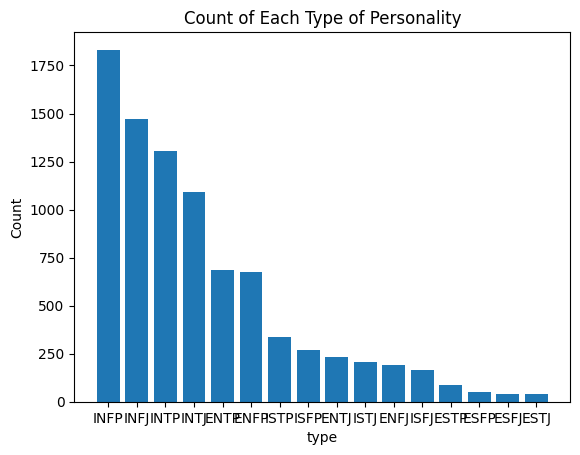

In [67]:
type_counts = mbti_data["type"].value_counts()

plt.bar(type_counts.index, type_counts.values)
plt.xlabel("type")
plt.ylabel('Count')
plt.title('Count of Each Type of Personality')
plt.show()

Here we can see that there are definitely a disparity about the different types of personality, in terms of the data given
- as a result I decided to get an equal amount of data for uniform spread
- and therefore cut the number of rows per type 

## 4. cleaning the data

In [111]:
mintype = 'ESTJ'

justMin = mbti_data[mbti_data["type"] == mintype]
mintype_rows = justMin.shape[0]

print(f"Number of rows of min '{mintype}': {mintype_rows}")

Number of rows of min 'ESTJ': 0


In [69]:
## this didn't work...

# # create a temp dataframe for each type to then cut to the min rows per type
# for type in mbti_type:
#     temp_type_df = mbti_data[mbti_data["type"] == type]
#     temp_type_df = temp_type_df.head(mintype_rows)

#     mbti_data = pd.concat([mbti_data[mbti_data["type"]!= mintype], temp_type_df])

check to see if the data has been "equalized" across the mbti types

In [89]:
mbti_data = mbti_data.groupby('type').apply(lambda x: x.sample(n=39, random_state=1)).reset_index(drop=True) 

/var/folders/7y/vhmh51616wg6bkp5k64sq0j40000gn/T/ipykernel_95234/3523821450.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mbti_data = mbti_data.groupby('type').apply(lambda x: x.sample(n=39, random_state=1)).reset_index(drop=True)


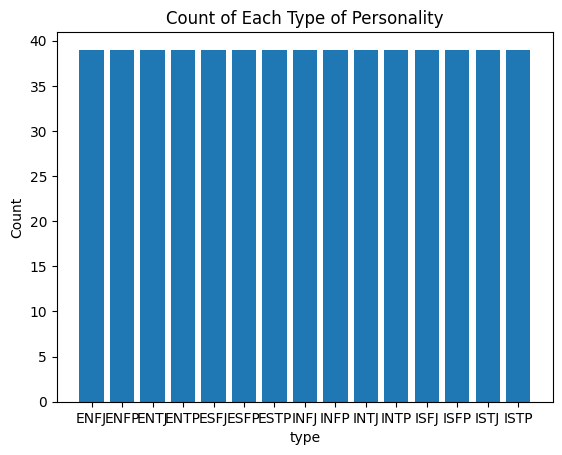

In [90]:
type_counts2 = mbti_data["type"].value_counts()

plt.bar(type_counts2.index, type_counts2.values)
plt.xlabel("type")
plt.ylabel('Count')
plt.title('Count of Each Type of Personality')
plt.show()

## 5. preparing for analysis

In [97]:
mbti_type = ["ESTJ", "ENTJ", "ESFJ", "ENFJ", "ISTJ", "ISFJ", "INTJ", "INFJ", "ESTP", "ESFP", "ENTP", "ENFP", "ISTP", "ISFP", "INTP", "INFP"]
mbti_dict = {}

for mbti in mbti_type:
    mbti_dict[mbti] = MBTI(mbti)

def fill_posts(line):
    mbti_dict[line["type"]].add_posts(line["posts"])

mbti_data.apply(lambda line: fill_posts(line), axis=1)

for mbti in mbti_type:
    mbti_dict[mbti].clean_posts



# SENTIMENT ANALYSIS

In [102]:
# create a new dataframe to store the different features: sentiment analysis
df_predict = pd.DataFrame(mbti_dict.keys(), columns=["Type"])

# ensures that the og data frame isn't changed as df_predict is
df_predict = df_predict.copy()

In [103]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /Users/renakim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/renakim/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/renakim/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [104]:
df_temp = df_predict.loc[df_predict["Type"] == "INTJ"]
df_temp = df_temp.copy()

,Type
6,INTJ


In [109]:
# Sentiment Analysis
sia = SentimentIntensityAnalyzer()

# Return the sentiment score of each post
def get_polarity_scores(type):
    posts = mbti_dict[type].get_posts()

    neg = 0.0
    pos = 0.0
    neu = 0.0
    compound = 0.0

    num_posts = len(posts)

    for post in posts:
        scores = sia.polarity_scores(post)
        neg += scores['neg']
        pos += scores['pos']
        neu += scores['neu']
        compound += scores['compound']

    avg_neg = neg / num_posts
    avg_pos = pos / num_posts
    avg_neu = neu / num_posts
    avg_compound = compound / num_posts

    # return the total polarity scores for each
    return avg_neg, avg_pos, avg_neu, avg_compound

In [108]:
# try it on just one mbti type
# INTJ took 1 min 7.1 sec
results = df_temp["Type"].apply(lambda x: get_polarity_scores(x)).apply(pd.Series)
results.columns = ['Negative', 'Positive', 'Neutral', 'Compound']

df_temp.loc[:, ['Negative', 'Positive', 'Neutral', 'Compound']] = results
print(df_temp)

   Type  Negative  Positive   Neutral  Compound
6  INTJ  0.070054  0.148472  0.778612  0.208294


I had to test it out on just the df_temp (aka one MBTI type row) because it took a while to load. This is what I used during my debugging process. Once I could confirm it worked, I applied it to the whole df_predict df

In [ ]:
results = df_predict["Type"].apply(lambda x: get_polarity_scores(x)).apply(pd.Series)
results.columns = ['Negative', 'Positive', 'Neutral', 'Compound']

df_predict.loc[:, ['Negative', 'Positive', 'Neutral', 'Compound']] = results
print(df_predict)